# Intro to pyEMU

This notebook provides a quick run through some of the capabilities of `pyemu` for working with PEST(++). This run through is very "high level". We will not go into detail, merely show some of the core functionality as a primer for subsequent tutorials. We assume the reader has at least some understanding of PEST(++), common file structures and workflows.

The notebook will make use of an existing PEST(++) interface. You do not need to be familiar with the details of the setup for the purposes of the current tutorial. 

In the current tutorial notebook, we will:
 - introduce how to access and edit an existing PEST control file and setup using the `Pst` class.
 - explore some of the built-in methods for customing PEST setups and post-processing outcomes.
 - introduce geostats in `pyemu`.
 - introduce methods for handling matricies with the `Matrix` class, as special instances with the `Cov` and `Jco` classes.
 - introduce classes that facilitate generating and handling parameter and obsveration Ensembles.

Here we **do not** demonstrate how to setup a PEST interface from scratch. See the "freyberg_pstfrom_pest_setup" tutorial for a demonstration on how to use the `PstFrom` class to do so.

### 1. Admin

In [1]:
import os
import shutil
import pyemu
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.pyplot as plt
import numpy as np

In the tutorial directory there is a folder named `handling_files`. This folder contains the PEST(++) dataset which we will access. Feel free to explore it if you wish. 

Amongst other things, it includes:

 - PEST(++) control file: `freyberg_pp.pst` 
 - A Jacobian matrix produced by PEST: `freyberg_pp.jcb` 
 - Parameters assigned using pilot points. These are recorded in the pilot point file: `hkpp.dat.tpl`

In [2]:
# the pest folder
f_d = os.path.join('handling_files')

### 2. The `Pst` class

`pyEMU` encapsulates the PEST control file in the `Pst` class. Let's read the `freyberg_pp.pst` control file in the `f_d` folder.

In [3]:
pst = pyemu.Pst(os.path.join(f_d,"freyberg_pp.pst"))

From the `pst` instance, we can access all the "*" sections of the control file. Each of these is stored as an attribute.  PEST variable names are used for consistency. 

For example, the "* *parameter data*" section can be accessed by calling `pst.parameter_data`. This returns the parameter data as a `Pandas` DataFrame, making it easy to access and edit. 

In [4]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk00,hk00,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk01,hk01,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk02,hk02,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk03,hk03,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN
hk04,hk04,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,NaN


The same for "* *observation data*":

In [5]:
pst.observation_data.head()

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.661526,5.0,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.460564,5.0,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.513522,5.0,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.741689,5.0,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.871208,5.0,calhead,NaN


You can access, slice and edit `parameter_data` or `observation_data` just as you would a DataFrame. You can add columns, these will not be writen to the control file. `pyemu` is clever like that.

In [6]:
pst.parameter_data.columns

Index(['parnme', 'partrans', 'parchglim', 'parval1', 'parlbnd', 'parubnd',
       'pargp', 'scale', 'offset', 'dercom', 'extra'],
      dtype='object')

It's best not to mess around with parameter names (`parnme`). If you do, you will need to make sure that the corresponding names appear in a `.tpl` file. (The same applies for observation names and `.ins` files.) 

You can edit values like so:


In [7]:
#assing values to all parameter intial values
pst.parameter_data['parval1'] = 1.1

# the pandas .loc method makes for easy slicing and dicing
pst.parameter_data.iloc[:3,:] 

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk00,hk00,log,factor,1.1,0.5,50.0,hk,1.0,0.0,1,NaN
hk01,hk01,log,factor,1.1,0.5,50.0,hk,1.0,0.0,1,NaN
hk02,hk02,log,factor,1.1,0.5,50.0,hk,1.0,0.0,1,NaN


#### 2.1. Control Data Section

The "* control data" section is handled by a special class that tries to prevent mistakes. `pyemu` will not allow you to assign an illogical value to a control data variable. This avoids silly mistakes. But it also requires that the user must know what type(s) can be passed to each data variable.

For example, NOPTMAX can only be assigned an integer. If you try to assign text, you will get an error. Try replacing the value 0 in the next cell with the string "zero":


In [8]:
pst.control_data.noptmax = 0 # replace 0 with "zero" and see what happens

We can inspect all control data values using the `pst.control_data.formatted_values` attribute:

In [9]:
pst.control_data.formatted_values

name
rstfle                        restart
pestmode               regularization
npar                               48
nobs                             1013
npargp                              6
nprior                            422
nobsgp                             26
maxcompdim                          0
ntplfle                             6
ninsfle                             5
precis                         single
dpoint                          point
numcom                              1
jacfile                             0
messfile                            0
obsreref                   noobsreref
rlambda1                 2.000000E+01
rlamfac                 -3.000000E+00
phiratsuf                3.000000E-01
phiredlam                1.000000E-02
numlam                             -7
jacupdate                         999
lamforgive                 lamforgive
derforgive               noderforgive
relparmax                1.000000E+01
facparmax                1.000000E+01
facorig

#### 2.2. PEST++ Options

PEST++ options are stored in a dictionary in which the `keys` are the PEST++ Control Variable name (see the PEST++ user manual for names of these variables and their descriptions). Values must be asigned according to what PEST++ expects as input.

You can access the existing PEST++ options like so:

In [10]:
pst.pestpp_options

{'n_iter_base': '-1',
 'lambda_scale_fac': '1.0',
 'n_iter_super': '3',
 'lambdas': '0.1,1.0,10.0',
 'forecasts': 'travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231',
 'upgrade_augment': 'false'}

You can change the values of existing control variables like so:

In [11]:
# changes the value for the PEST++ option 'ies_parameter_ensemble'
pst.pestpp_options['ies_parameter_ensemble'] = 'dummy_ies_par_ensemble.csv'

# check the dictionary again
pst.pestpp_options

{'n_iter_base': '-1',
 'lambda_scale_fac': '1.0',
 'n_iter_super': '3',
 'lambdas': '0.1,1.0,10.0',
 'forecasts': 'travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231',
 'upgrade_augment': 'false',
 'ies_parameter_ensemble': 'dummy_ies_par_ensemble.csv'}

Or add new PEST++ variables like so:

In [12]:
# A few examples of adding PEST++ options of different types:
# pestpp-ies; the number of realizations to draw in order to form parameter and observation ensembles.
pst.pestpp_options['ies_num_reals'] = 50

# specifies a list of values for the Marquardt lambda used in calculation of parameter upgrades. 
pst.pestpp_options["lambdas"] = [0.1, 1, 10, 100, 1000]

# pestpp-da; True/False, specify whether to use the simulated states at the end of each cycle as the initial states for the next cycle.   
pst.pestpp_options['da_use_simulated_states'] = True

# check the dictionary again
pst.pestpp_options

{'n_iter_base': '-1',
 'lambda_scale_fac': '1.0',
 'n_iter_super': '3',
 'lambdas': [0.1, 1, 10, 100, 1000],
 'forecasts': 'travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231',
 'upgrade_augment': 'false',
 'ies_parameter_ensemble': 'dummy_ies_par_ensemble.csv',
 'ies_num_reals': 50,
 'da_use_simulated_states': True}

#### 2.3. Writing the .pst control file

All of these edits are kept in memory untill explicitly written to a .pst file. This is accomplished with the `Pst.write()` method.

The control file can be written as version 1 or 2 (see the PEST++ user manual for descriptions of versions). Unlike the original PEST version 1, version 2 control files have each of the "*" sections stored in external csv files. This makes them easier to access and manipulate, either programatically or using common spreadsheet software. PEST and PEST_HP only accept version 1. Only PEST++ accepts version 2. If there are more than 10k parameters, version 2 is written by default. 

You can specify the version by passing the relevant argument. Run the cells below then inspect the folder to see the differences.

In [13]:
pst.write(os.path.join(f_d, 'temp.pst'), version=1)

noptmax:0, npar_adj:48, nnz_obs:14


In [14]:
pst.write(os.path.join(f_d, "temp_v2.pst"), version=2)

noptmax:0, npar_adj:48, nnz_obs:14


In [15]:
[f for f in os.listdir(f_d) if f.endswith('.pst')]

['freyberg_pp.pst', 'temp.pst', 'temp_v2.pst', 'test.pst', 'test2.pst']

#### 2.4. Adding Parameters/Observations from .tpl/.ins files

In another tutorial we demonstrate the use of the `PstFrom` to automate construction of a complete PEST interface, starting from scratch.

Alternatively, it is possible to construct a PEST control file from template (.tpl) and instruction (.ins) files. The `Pst` class includes methods to read .tpl/.ins files and add parameters/observations to the control file. This enables construction of a PEST dataset, or simply adding new ones to an existing control file. It is particularily usefull for pesky model input/output files with inconvenient file structures (e.g. that are not array or tabular formats).

The cell bellow writes a "dummy" template file to the tutorial folder for demonstration purposes. 

In [16]:
tpl_filename = os.path.join(f_d,"special_pars.dat.tpl")
with open(tpl_filename,'w') as f:
    f.write("ptf ~\n")
    f.write("special_par1  ~  special_par1   ~\n")
    f.write("special_par2  ~  special_par2   ~\n")

Adding the parameters from "special_pars.dat.tpl" to the control file is a simple matter of calling the `.add_parameters()` method. This method adds the parameters to the `pst.parameter_data` section, and updates other relevant sections of the `pst` control file; it also returns a DataFrame. Note that parameter names come from the .tpl file. However, intial values, bounds and group name are assigned default values; you will need to specify correct values before writing the control file to disk.

In [17]:
pst.add_parameters(tpl_filename, pst_path=".") #pst_path is the relative path from the control file to the .tp file

2 pars added from template file .\special_pars.dat.tpl


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
special_par1,special_par1,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
special_par2,special_par2,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


You can then adjust parameter data details:

In [18]:
# assign to variable to make code easier to read
par = pst.parameter_data

# adjust parameter bounds; don't worry about this now
par.loc[par['pargp'] == 'pargp', ['parlbnd', 'parubnd']] = 0.1, 10

par.loc[par['pargp'] == 'pargp']

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
special_par1,special_par1,log,factor,1.0,0.1,10.0,pargp,1.0,0.0,1,NaN
special_par2,special_par2,log,factor,1.0,0.1,10.0,pargp,1.0,0.0,1,NaN


#### 2.5. Tying Parameters

We may on ocasion need to tie parameters in the control file. In the `pyemu` world, tied parametes are specified in the `Pst.parameter_data` dataframe. Start by adding a `partied` column and, for parameters you want to tie, changing "partrans" to "tied" and adding the name of the parameter to tie to in the "partied" column. 

We will demonstrate step-by-step by tying "special_par2" to "special_par1" (the parameters we just added from the .tpl file):

In [19]:
# see the parameters
par.loc[par['pargp'] == 'pargp']

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
special_par1,special_par1,log,factor,1.0,0.1,10.0,pargp,1.0,0.0,1,NaN
special_par2,special_par2,log,factor,1.0,0.1,10.0,pargp,1.0,0.0,1,NaN


In [20]:
# set the partrans for "special_par2" as "tied"
par.loc['special_par2', 'partrans'] = 'tied'

# add a new column named "partied" and assign the parameter name to which to tie "special_par2"
par.loc['special_par2', 'partied'] = 'special_par1'

# display for comparison; see partrans and partied columns
par.loc[par['pargp'] == 'pargp', ['partrans', 'partied']]

,partrans,partied
special_par1,log,NaN
special_par2,tied,special_par1


### 3. Utilities

`pyemu` has several built-in methods to make your PEST-life easier. Several of these handle similar tasks as utilities from the PEST-suite, such as adjusting observation weights and assigning prior information equations. Others provide usefull tables or plots that summarize details of the PEST setup and/or outcomes.

#### 3.1. Par and Obs Summaries
You can access quick summaries of observation and paramaeter names, group names, etc thorugh the respective `pst` attributes:

In [21]:
# non-zero weighted observation groups, returns a list. 
# Here it sliced to the first 5 elements to keep it short
pst.nnz_obs_groups[:5]

['calhead', 'calflux']

In [22]:
# number of non-zero observations and adjustable parmaeters
pst.nnz_obs, pst.npar_adj

(14, 49)

In [23]:
# adjustble parameter group names
pst.adj_par_groups[:5]

['hk', 'porosity', 'rch', 'sfr', 'w0']

You can write a parameter or observation summary table wth the `Pst.write_par_symmary_table()` and `Pst.write_obs_symmary_table()` methods, respectively. Quite usefull when preparing those pesky reports. 

These methods return a Pandas DataFrame and (by default) write the table to an external file. Parameters and observations are summarized by group name.

In [24]:
pst.write_par_summary_table()

,type,transform,count,initial value,lower bound,upper bound,standard deviation
hk,hk,log,32,0.0413927,-0.30103,1.69897,0.5
pargp,pargp,mixed,2,0 to 1,-1 to 0.1,1 to 10,0.5 to 2.475
porosity,porosity,log,1,0.0413927,-2.30103,-1.69897,0.150515
rch,rch,log,2,0.0413927,-0.60206 to -0.30103,0.30103 to 0.477121,0.150515 to 0.269795
sfr,sfr,log,1,0.0413927,-2,1,0.75
w0,w0,log,6,0.0413927,-0.30103,0.30103,0.150515
w1,w1,log,6,0.0413927,-1,1,0.5


In [25]:
pst.write_obs_summary_table()

,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
calflux,calflux,3242.6,1,0,0.05,20,0.616789
calhead,calhead,15.7487 to 30.7417,13,0,5,0.2,0.650582 to 1.26995
flaqx,flaqx,-895.43 to 252.98,0,122,0,NA,NA
flout,flout,0 to 7229.3,0,122,0,NA,NA
flx_constan,flx_constan,-860.052 to -490.431,0,3,0,NA,NA
flx_in-out,flx_in-out,-2.9966 to 1.3086,0,3,0,NA,NA
flx_percent,flx_percent,-0.05 to 0.02,0,3,0,NA,NA
flx_recharg,flx_recharg,3475 to 6004.8,0,3,0,NA,NA
flx_storage,flx_storage,0 to 1578.27,0,3,0,NA,NA
flx_stream_,flx_stream_,-3242.62 to -603.149,0,3,0,NA,NA


### 3.2. Phi and residuals

The `Pst` class tries to load a residuals file iduring construction. It looks for a file in the same folder as the control file and with the same base name, but with the extension ".rei". Alterantaively, you can specify the name of the residual file when constructing the `Pst`. (e.g. `pyemu.Pst("controlfile.pst", resfile="residualfile.rei")`)

If that file is found, you can access some pretty cool stuff.  The `Pst.res` attribute is stored as a Pandas DataFrame. 

Of course, all of this relies on PEST(++) having been run at least once before hand to record the residuals file. For the purposes of this tutorial, we have already done so. When we constructed `pst` at the beggining of this notebook, `pyemu` also loaded the residuals file. 

Inspect it by running the cell bellow. As you can see, the DataFrame lists all observations and group names, their modelled and measured values, weights and of course the residual:


In [26]:
pst.res.head()

,name,group,measured,modelled,residual,weight
name,,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,calhead,26.661526,28.013775,-1.352249,5.0
c001cr03c16_19700102,c001cr03c16_19700102,calhead,23.460564,24.444290,-0.983726,5.0
c001cr04c09_19700102,c001cr04c09_19700102,calhead,28.513522,28.513071,0.000451,5.0
c001cr10c02_19700102,c001cr10c02_19700102,calhead,30.741689,31.881250,-1.139561,5.0
c001cr14c11_19700102,c001cr14c11_19700102,calhead,25.871208,25.444475,0.426733,5.0


A somewhat clunky (and meaningless) look at everyones favourite "good fit" plot:

<AxesSubplot:xlabel='measured', ylabel='modelled'>

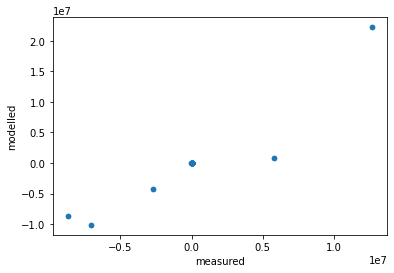

In [27]:
pst.res.plot.scatter('measured', 'modelled')

Or a clunky look at the residuals for selected observations:

<AxesSubplot:xlabel='name'>

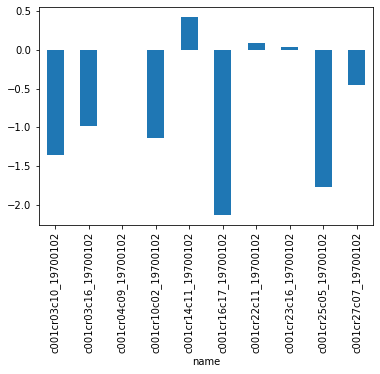

In [28]:
pst.res.iloc[:10].loc[:, 'residual'].plot(kind='bar')

There are built in routines for some common plots. These can be called with the `Pst.plot()` method and specifying the `kind` argument. For example, a 1to1 plot for each observation group: 

<Figure size 576x756 with 0 Axes>

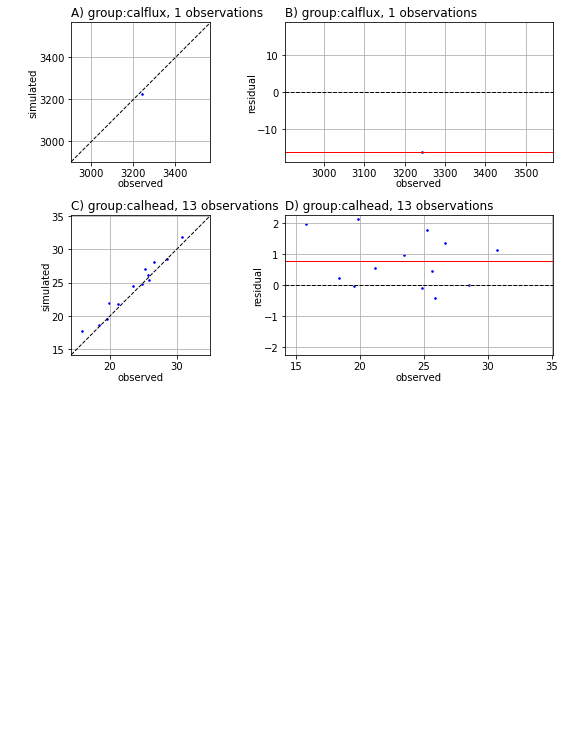

In [29]:
# 1to1 plots are displayed for each observationg group with non-zero weighted observations
pst.plot(kind='1to1');

The weighted sum of square residuals (Phi) is also stored in the respective `Pst` attribute. 

In [30]:
# the value of the objective function
pst.phi

412.55703718999166

We can access the components of the objective function as a dictionary. These allow us to breakdown the contributions to Phi from each observation group:

In [31]:
# observation group contributions to Phi
pst.phi_components

{'calflux': 0.6560999999999854,
 'calhead': 411.9009371899917,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

They can also be displayed with a plot, like so:

412.55703718999166 {'calflux': 0.6560999999999854, 'calhead': 411.9009371899917, 'flaqx': 0.0, 'flout': 0.0, 'flx_constan': 0.0, 'flx_in-out': 0.0, 'flx_percent': 0.0, 'flx_recharg': 0.0, 'flx_storage': 0.0, 'flx_stream_': 0.0, 'flx_total': 0.0, 'flx_wells': 0.0, 'forecast': 0.0, 'pothead': 0.0, 'vol_constan': 0.0, 'vol_in-out': 0.0, 'vol_percent': 0.0, 'vol_recharg': 0.0, 'vol_storage': 0.0, 'vol_stream_': 0.0, 'vol_total': 0.0, 'vol_wells': 0.0} {'calflux': 0.0015903255570885748, 'calhead': 0.9984096744429114, 'flaqx': 0.0, 'flout': 0.0, 'flx_constan': 0.0, 'flx_in-out': 0.0, 'flx_percent': 0.0, 'flx_recharg': 0.0, 'flx_storage': 0.0, 'flx_stream_': 0.0, 'flx_total': 0.0, 'flx_wells': 0.0, 'forecast': 0.0, 'pothead': 0.0, 'vol_constan': 0.0, 'vol_in-out': 0.0, 'vol_percent': 0.0, 'vol_recharg': 0.0, 'vol_storage': 0.0, 'vol_stream_': 0.0, 'vol_total': 0.0, 'vol_wells': 0.0}


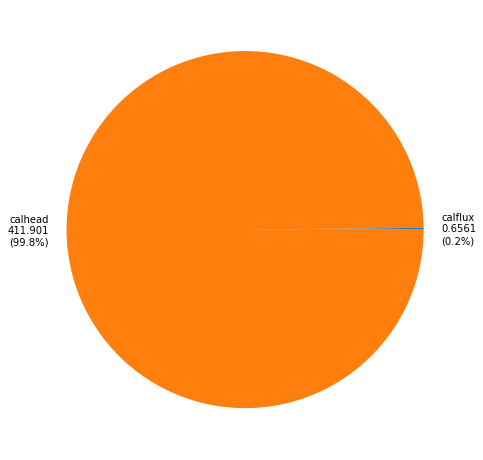

In [32]:
pst.plot(kind="phi_pie");

These values can be recalculated for different observation weights by simply changing the weights in the `pst.observation_data`. No need to re-run PEST!

In [33]:
obs = pst.observation_data
# change all observation weights
obs['weight'] = 1.0

# check the phi contributions again; compare to vaues displayed above
pst.phi_components

{'calflux': 262.4399999999941,
 'calhead': 16.476037487599665,
 'flaqx': 1833954.6605177554,
 'flout': 197878154.4605563,
 'flx_constan': 676008.59199331,
 'flx_in-out': 1891.6393557325607,
 'flx_percent': 0.3906,
 'flx_recharg': 13715682.302664,
 'flx_storage': 1790807.6099523597,
 'flx_stream_': 4606580.736118089,
 'flx_total': 1891.6432934656098,
 'flx_wells': 9002.21440000002,
 'forecast': 35650091.62401858,
 'pothead': 331.3388554798862,
 'vol_constan': 4632350392780.079,
 'vol_in-out': 2194665563.259239,
 'vol_percent': 0.40590000000000004,
 'vol_recharg': 181050529666933.2,
 'vol_storage': 47716024806972.54,
 'vol_stream_': 18909905120606.703,
 'vol_total': 2194665563.2629757,
 'vol_wells': 27052.21440000002}

### 3.3. Adjusting Weights for "Visibility"

Prior to estimating parameters using PEST(++), a user must decide how to weight observations. In some
cases, it is wise to weight observations strictly according to the inverse of the standard deviation of
measurement noise. Certainly, observations of greater credibility should be given greater weights
than those of lower credibility. 

However, when history-matching, this approach can result in the loss of information contained in some observations, due to their contribution to the objective function being over-shadowed by the contribution from other obsevrations. An alternative approach is to weight observations (or observation groups) such that, at the start of the history-matching process, they each contribute the same amount to the objective function. The information content of each of these groups is thereby given equal right of entry to the parameter estimation process. (This matter is extensively discussed in the PEST Book.)

As stated above, a practical means of accommodating this situation is to weight all observation groups
such that they contribute an equal amount to the starting measurement objective function. In this
manner, no single group dominates the objective function, or is dominated by others; the information
contained in each group is therefore equally “visible” to PEST(++).

The `Pst.adjust_weights()` method provides a mechanism to fine tune observation weights according to their contribution to the objective function. (*Side note: the PWTADJ1 utility from the PEST-suite automates this same process of "weighting for visibility".*) 

Some **caution** is required here. Observation weights and how these pertain to history-matching *versus* how they pertain to generating an observation ensemble for use with `pestpp-ies` is a frequent source of confusion.

 - when **history-matching**, observation weights listed in the control file determine their contribution to the objective function, and therefore to the parameter estiamtion process. Here, observation weights may be assigned to reflect observation uncertainty, the balance required for equal "visibility", or other modeller-defined (and perhaps subjective...) measures of observation worth.  
 - when **generating an observation ensemble**, weights should reflect the inverse of the standard deviation of measurement noise. However, unless instructed otherwise, `pestpp-ies` will generate the observation ensemble *using observation weights in the PEST control file*. Therefore, when history-matching with `pestpp-ies` and using weights that **do not** reflect observation uncertainty, it is important to provide `pestpp-ies` with a previously prepared observation ensemble (we will demonstrate this further on).

OK, so let's adjust some observation weights using `Pst.adjust_weights()`. This method allows us to adjust weights for individual observations, or for entire observation groups. We do so by passing a dictionary with observation names (or group names) as keys, and the correspding value they contribute to the objective function as values.

Let's get started.

In [34]:
# check the phi contributions
pst.phi_components

{'calflux': 262.4399999999941,
 'calhead': 16.476037487599665,
 'flaqx': 1833954.6605177554,
 'flout': 197878154.4605563,
 'flx_constan': 676008.59199331,
 'flx_in-out': 1891.6393557325607,
 'flx_percent': 0.3906,
 'flx_recharg': 13715682.302664,
 'flx_storage': 1790807.6099523597,
 'flx_stream_': 4606580.736118089,
 'flx_total': 1891.6432934656098,
 'flx_wells': 9002.21440000002,
 'forecast': 35650091.62401858,
 'pothead': 331.3388554798862,
 'vol_constan': 4632350392780.079,
 'vol_in-out': 2194665563.259239,
 'vol_percent': 0.40590000000000004,
 'vol_recharg': 181050529666933.2,
 'vol_storage': 47716024806972.54,
 'vol_stream_': 18909905120606.703,
 'vol_total': 2194665563.2629757,
 'vol_wells': 27052.21440000002}

Now, let's create the dictionary of non-zero weighted observation groups. We will specify that we want each group to contribute a value of 100 to the objective function. (Why 100? No particular reason. Could just as easily be 1000. Or 578. Doesn't really matter. 100 is a nice round number though.)

In [35]:
balanced_groups = {grp:100 for grp in pst.nnz_obs_groups}
balanced_groups

{'calhead': 100,
 'forecast': 100,
 'pothead': 100,
 'flaqx': 100,
 'flx_constan': 100,
 'flx_in-out': 100,
 'flx_percent': 100,
 'flx_recharg': 100,
 'flx_storage': 100,
 'flx_stream_': 100,
 'flx_total': 100,
 'flx_wells': 100,
 'flout': 100,
 'calflux': 100,
 'vol_constan': 100,
 'vol_in-out': 100,
 'vol_percent': 100,
 'vol_recharg': 100,
 'vol_storage': 100,
 'vol_stream_': 100,
 'vol_total': 100,
 'vol_wells': 100}

Now we can simply pass this dictionary as an argument:

In [36]:
# make all non-zero weighted groups have a contribution of 100.0
pst.adjust_weights(obsgrp_dict=balanced_groups,)

And voila. Run the cell below to see that phi components form each group are (roughly) 100. The same approach can be implemented for individual observations (see the `obs_dict` argument in `pst.adjust_weights()`). 

In [37]:
# check the phi contributions; comapre to those above
pst.phi_components

{'calflux': 100.0,
 'calhead': 100.00000000000001,
 'flaqx': 100.00000000000003,
 'flout': 99.99999999999999,
 'flx_constan': 100.0,
 'flx_in-out': 100.00000000000001,
 'flx_percent': 99.99999999999999,
 'flx_recharg': 99.99999999999997,
 'flx_storage': 100.0,
 'flx_stream_': 100.00000000000001,
 'flx_total': 100.00000000000001,
 'flx_wells': 100.0,
 'forecast': 100.00000000000003,
 'pothead': 100.00000000000001,
 'vol_constan': 100.00000000000001,
 'vol_in-out': 100.0,
 'vol_percent': 99.99999999999999,
 'vol_recharg': 100.00000000000001,
 'vol_storage': 100.00000000000001,
 'vol_stream_': 99.99999999999997,
 'vol_total': 100.00000000000003,
 'vol_wells': 100.00000000000001}

2200.0 {'calflux': 100.0, 'calhead': 100.00000000000001, 'flaqx': 100.00000000000003, 'flout': 99.99999999999999, 'flx_constan': 100.0, 'flx_in-out': 100.00000000000001, 'flx_percent': 99.99999999999999, 'flx_recharg': 99.99999999999997, 'flx_storage': 100.0, 'flx_stream_': 100.00000000000001, 'flx_total': 100.00000000000001, 'flx_wells': 100.0, 'forecast': 100.00000000000003, 'pothead': 100.00000000000001, 'vol_constan': 100.00000000000001, 'vol_in-out': 100.0, 'vol_percent': 99.99999999999999, 'vol_recharg': 100.00000000000001, 'vol_storage': 100.00000000000001, 'vol_stream_': 99.99999999999997, 'vol_total': 100.00000000000003, 'vol_wells': 100.00000000000001} {'calflux': 0.045454545454545456, 'calhead': 0.04545454545454546, 'flaqx': 0.04545454545454547, 'flout': 0.04545454545454545, 'flx_constan': 0.045454545454545456, 'flx_in-out': 0.04545454545454546, 'flx_percent': 0.04545454545454545, 'flx_recharg': 0.04545454545454544, 'flx_storage': 0.045454545454545456, 'flx_stream_': 0.04545

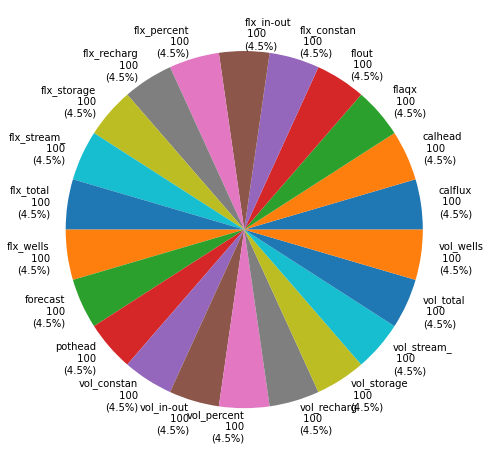

In [38]:
# comapre this plot to the one we generated earlier; this one is much more balanced
pst.plot(kind="phi_pie");

### 3.4. Discrepancy based weight adjustment

In a perfect (model and algorithm) world, we would acheive a final objective function that is equal to the number of (non-zero weighted) observations. But because of model error and simplifying assumptions in the algorithms we use for history matching, this is rarely the case.  More often, the final objective function is much larger than the number of observations.  This implies that we were not able to "fit" as well as we thought we could (where "thought" is incapsulated in the observations weights in the control file, representing the inverse of measurment noise).  This really matters when we do posterior uncertainty analyses following a PEST run (this will be discussed further in the FOSM and data-worth notebooks). 

The simpliest way to try to rectify this situation is to adjust the weights in the control file so that the resulting contribution to the objective function from each observation (or optional observation group) is equal to 1 (or the number of members of the group).  This is related to Morozov's discrepancy principal (google it!).  `pyEMU` has a built in routine to help with this: `Pst.adjust_weights_discrepancy()` - great name!

*Note 1: dont make this adjustment until after you are through with history matching! The point is for weights to represent the inverse of observation uncertainty, which includes both measurement error **and** model error.*

*Note 2: the PWTADJ2 utility from the PEST-suite acomplishes a similar task.*  

In [39]:
# see current phi and the number of non-zero observations
pst.phi, pst.nnz_obs

(2200.0, 1013)

In [40]:
pst.adjust_weights_discrepancy(original_ceiling=True) # default
# check the resulting phi
pst.phi

211.53558969631914

So we were expecting Phi to be equal to `nnz_obs` (number of non zero observations). This did not happen due to the `original_ceiling` argument being set to `True` (which is the default value).

What this means is that, for some observations, weights would have to be *increased* to achieve a contribution to Phi of 1.0. Which is illogical if the original weight is assumed to be the inverse of the measurement noise. In some cases, this requirement may not apply; such as when observatons are weighted for visibility.

### 4. Geostatistics in pyEMU

The `pyemu.geostats` module provides tools for implementing geostatistics in the `pyemu` world. These have similar functions to the PPCOV* utilities from the PEST suite. 

In the PEST world, geostatistics are used (1) to describe how parameters vary in space and/or time and (2) when assigning parameter values from pilot points to model input files. Front-end users will mostly be interested in the former. A separate tutorial notebook delves into geostatistics in greater detail. The "freyberg pest setup" tutorials provide examples of their use in the wild.

At the heart of geostatistics is some kind of model expressing the variability of properties in a field. This is a "variogram". `pyemu` supports spherical, exponential and gaussian variograms.

In [41]:
# exponential variogram for spatially varying parameters
v = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

In [42]:
# spherical variogram for spatially varying parameters
v2 = pyemu.geostats.SphVario(contribution=1.0, #sill
                                    a=500, # range of correlation
                                    anisotropy=1.5, #name says it all
                                    bearing=45.0, #angle in degrees East of North corresponding to anisotropy ellipse
                                    name='var2') #optional name

A `pyemu`  geostatistical structure object that mimics the behavior of a PEST geostatistical structure (see the PEST manual for details).  The object contains variogram instances, information on parameter transforms and
(optionally) nugget information. Multiple nested variograms are supported.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

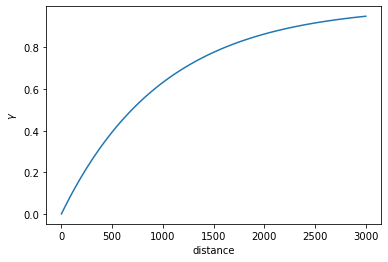

In [43]:
# geostatistical structure for spatially varying parameters
gs = pyemu.geostats.GeoStruct(variograms=[v], transform='log') 

# plot the gs if you like:
gs.plot()

Using the geostatistical structure (or a variogram), a covariance matrix describing the statistical relationship between spatialy distributed parameters can be constructed. These covariance matrices are used (1) to describe prior parameter probability distributions, and (2) specifying the weights of prior information equations as a regularisation device. 

For example, let's create a covariance matrix for a set of pilot point parameters from the `gs` structure. This requires a list of X and Y coordinates. Let's make use of the coordinates from a pilot points file in the `f_d` folder.

First, read the pilot points file to get X and Y values:

In [44]:
df = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(f_d,"hkpp.dat.tpl"))
df.head()

,name,x,y,zone,parnme
0,pp_0000,625.0,9375.0,1,hk00
1,pp_0001,1625.0,9375.0,1,hk01
2,pp_0002,2625.0,9375.0,1,hk02
3,pp_0003,3625.0,9375.0,1,hk03
4,pp_0004,625.0,8375.0,1,hk04


Now simply pass the respective values from the pilot points file as arguments to `gs.covariance_matrix()`. Conveniently, we can also take the parameter names from the pilot point file. This returns a `pyemu.Cov` object (which we will discuss later). The same can be complished with a single variogram (e.g. `v.covariance_matrix()`)

In [45]:
cov = gs.covariance_matrix(x=df.x, y=df.y, names=df.name)

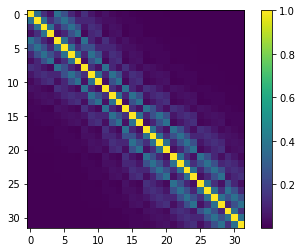

In [46]:
# just for a bit of eye-candy; bright yellow indicates higher covariance.
c = plt.imshow(cov.x)
plt.colorbar(c)

We can do the same thing for a 1-D sequence (think time-series), to get a covariance matrix for parameters distributed in time:

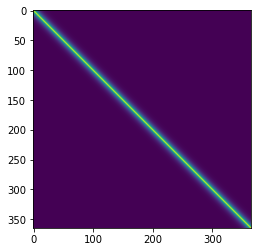

In [47]:
# let's make up a time-series
times = np.arange(0,365,1) # this is the "X" coordinate
y = np.ones_like(times)    # this is the "Y" coordinate
names = ["t_"+str(t) for t in times] # 'parameter" names

# make the variogram
exp_vario = pyemu.geostats.ExpVario(contribution=1.0,
                                    a=5 #range in time units (e.g. days)
                                    )
cov_t = exp_vario.covariance_matrix(times,y,names)
plt.imshow(cov_t.x)

### 5. Prior Information Equations

The mathematical term for the process through which a unique solution is sought for a nonunique
inverse problem is “regularisation”. The goal of regularised inversion is to seek a unique parameter
field that results in a suitable fit between model outputs and field measurements, whilst minimizing
the potential for wrongness in model predictions. That is, out of all the ways to fit a calibration dataset, regularized inversion seeks the parameter set of minimum error variance. (*Regularisation is discussed in greater detail in a separate notebook.*)

One way to seek a parameter field of minimum error variance is to seek a parameter field that allows
the model to fit the calibration dataset, but whose values are also as close as possible to a set of
“preferred parameter values”. Ideally, preferred parameter values should also be initial parameter
values as listed in the “parameter data” section of the PEST control file. These preferred parameter
values are normally close to the centre of the prior parameter probability distribution. At the same
time, scales and patterns of departures from the preferred parameter set that are required for model
outputs to fit a calibration dataset should be achieved in ways that make “geological sense”.

PEST provides a user with a great deal of flexibility in how Tikhonov constraints can be introduced to
an inversion process. The easiest way is to do this is through the use of prior information equations.
When prior information equations are employed, Tikhonov constraints are expressed through
preferred values that are assigned to linear relationships between parameters. (Equality is the simplest type of linear relationship.) Weights must be assigned to these equations. As is described in PEST documentation, when PEST is run in “regularisation” mode, it makes internal adjustments to the weights that are assigned to any observations or prior information equations that belong to special observation groups that are referred to as “regularisation groups”.

As for non-regularisation observations and prior information equations, weights can be replaced by
covariance matrices. These are rarely used with normal observations. However when observations
or prior information equations embody Tikhonov constraints, they can be used to ensure that patterns
of parameter heterogeneity that emerge from the inversion process are geologically reasonable.
Covariance matrices are preferred over weights for prior information equations that embody Tikhonov
constraints. 

*Note: in a similar manner, the PEST-utilities ADDREG1 and ADDREG2 also automate the addition of prior information equations to a PEST-control file.*

### 5.1. Preffered value or Zero Order Tikhonov

`pyemu` provides utilities to apply preferred value prior equations to a PEST control file. Note though, pyemu doesn't call it "preferred value"! Rather, it uses the mathematical term "Zero Order Tikhonov".

Before we do so, we can inspect the control file "* prior information" section. As you may have guessed, this is accessed using the `pst.prior_information` attribute, which returns a `DataFrame`:


In [48]:
pst.prior_information.head()

,pilbl,equation,weight,obgnme,extra,names
pilbl,,,,,,
rch_0,rch_0,1.0 * log(rch_0) = 0.000000E+00,1.660964,regulrch,NaN,[rch_0]
rch_1,rch_1,1.0 * log(rch_1) = 0.000000E+00,0.926628,regulrch,NaN,[rch_1]
w0_r09_c16,w0_r09_c16,1.0 * log(w0_r09_c16) = 0.000000E+00,1.660964,regulw0,NaN,[w0_r09_c16]
w0_r11_c13,w0_r11_c13,1.0 * log(w0_r11_c13) = 0.000000E+00,1.660964,regulw0,NaN,[w0_r11_c13]
w0_r20_c14,w0_r20_c14,1.0 * log(w0_r20_c14) = 0.000000E+00,1.660964,regulw0,NaN,[w0_r20_c14]


In [49]:
# use pyemu to apply preferred value (aka zero order Tikhonov) to all adjustable parameter groups
pyemu.helpers.zero_order_tikhonov(pst,
                                par_groups=pst.adj_par_groups, # par groups for which prior inf eq are added
                                reset=True) # whether to remove existing prior equations first; default is true

Now, as you can see below, prior information equations have been added for all adjustable parameters. The "preferred value" is obtained from the parameter initial value in the "* parameter_data" section. The weight is calculated from the parameter bounds (this behaviour can be changed with arguments in `pyemu.helpers.zero_order_tikhonov()`).

In [50]:
pst.prior_information.head()

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 4.139269E-02,regulhk,0.5
hk01,hk01,1.0 * log(hk01) = 4.139269E-02,regulhk,0.5
hk02,hk02,1.0 * log(hk02) = 4.139269E-02,regulhk,0.5
hk03,hk03,1.0 * log(hk03) = 4.139269E-02,regulhk,0.5
hk04,hk04,1.0 * log(hk04) = 4.139269E-02,regulhk,0.5


### 5.2. Preferred difference or First Order Pearson Tikhonov

We may wish (almost certaintly) to express a preference for similarity between parameters. For example, hydraulic properties of two points close together are more likley to be similar to each other, than two points which are far apart. We describe this relationship using geostatistics, encapsulated in a covariance matrix.

As previously described, `pyemu.geostats` module provides tools for generating such matrices. The PEST suite also includes many utilities for this purpose (see the PPCOV* set of utilities.)
Let's use the `cov` covariance matrix we constructed earlier for the set of pilot points.

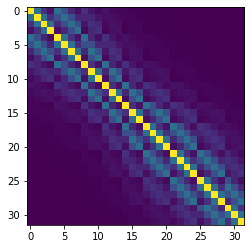

In [51]:
# a reminder
plt.imshow(cov.x)

Now, we can assign prior information equations for preferred difference. Note that the preferred difference = 0, which means our preferred difference regularization is really a preferred *homogeneity* condition! If observation data doesn't say otherwise, parameters which are close together should be similar to each other.

The weights on the prior information equations are the Pearson correlation coefficients implied by the covariance matrix.

In [52]:
# then assign cov pror
pyemu.helpers.first_order_pearson_tikhonov(pst, 
                                            cov=cov,     # the covariance matrix; these can be for some OR all parameters in pst
                                            reset=False, # so as to have both prefered value and prefered differnece eqs
                                            abs_drop_tol=0.01) # drop pi eqs that have small weight

getting CC matrix
processing


In [53]:
# note the additional number of prior information equations
pst.prior_information.head()

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 4.139269E-02,regulhk,0.5
hk01,hk01,1.0 * log(hk01) = 4.139269E-02,regulhk,0.5
hk02,hk02,1.0 * log(hk02) = 4.139269E-02,regulhk,0.5
hk03,hk03,1.0 * log(hk03) = 4.139269E-02,regulhk,0.5
hk04,hk04,1.0 * log(hk04) = 4.139269E-02,regulhk,0.5


### 5.3. Custom Prior Information Equations

`Pst.add_pi_equation()` is a helper to construct prior information equations. We demonstrate below using the "special_par"s we added earlier.

In [54]:
# reminder
par = pst.parameter_data
# let's just un-tie special_par2, otherwise we can't assign a prior info euqation using it
par.loc[par['pargp']=='pargp', 'partrans'] = 'log'
#display
par.loc[par['pargp']=='pargp']

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra,partied
parnme,,,,,,,,,,,,
special_par1,special_par1,log,factor,1.0,0.1,10.0,pargp,1.0,0.0,1,NaN,NaN
special_par2,special_par2,log,factor,1.0,0.1,10.0,pargp,1.0,0.0,1,NaN,special_par1


In [55]:
pst.add_pi_equation(
                    par_names=['special_par1', 'special_par2'], # list of parameter names included on the left hand side of the equation
                    pilbl='new_pi_eq',
                    rhs=0.0, # the value on the right hand side of the equation; make sure that this value is logical. you may also wish to check if it conflicts with existing prior information equations
                    weight=1.0, # the weight assigned to the prior information equation
                    obs_group='regul_special', # name to assign to the prior information "observationg group"
                    coef_dict = {'special_par1':1.0, 'special_par2':0.5} # dictionary of parameter coeficients; try specifying different values, note how the equation changes
                    )

# let's take a look; just print the last row (e.g. the latest prior info equation)
pst.prior_information.iloc[-1:]


,pilbl,equation,obgnme,weight
pilbl,,,,
new_pi_eq,new_pi_eq,1.0 * log(special_par1) + 0.5 * log(special_par2) = 0.0,regul_special,1.0


### 6. Matrices

The `pyemu.Matrix` class is the backbone of `pyemu`. The `Matrix` class does some fancy things in the background to make manipulating matrices and linear algebra easier. The class overloads all common mathematical operators and also uses an "auto-align" functionality to line up matrices for multiplication, addition, etc. The `pyemu.Jco` class provides a wrapper to deal with PEST Jacobian matrices. It functions the same as the `Matrix` class.

The `pyemu.Cov` class is a special class designed specifically to handle covariance matrices. (We have already seen examples of the `pyemu.Cov` earlier.) The `Cov` class makes some assumptions, such as symmetry (and accordingly that matrix rows and columns names are equal) and provides additional functionality.

All classes provide functionality to record matrices to, as well as read from, external files in PEST-compatible formats (e.g. ASCII or binary). `Cov` can also write PEST uncertainty (*.unc) files. The `Cov` class has additional functionality that allows covariance matrices to be constructed from information contained in PEST control files (e.g. from parameter or observation bounds). 

In [56]:
# generate covariance matrix from parameter bounds
parcov = pyemu.Cov.from_parameter_data(pst)

# generate a covariance matrix from observation data (e.g. weights):
obscov = pyemu.Cov.from_observation_data(pst)

As you can see below, the `Cov` object retains the parameter names as row and column names.

In [57]:
# the first 5 row and col names 
parcov.row_names[:5], parcov.col_names[:5], 

(['hk00', 'hk01', 'hk02', 'hk03', 'hk04'],
 ['hk00', 'hk01', 'hk02', 'hk03', 'hk04'])

We can check if the matrix is diagonal with the `.isdiagonal` attribute. 

In [58]:
parcov.isdiagonal

True

How about the `cov` covariance matrix we generated earlier for spatialy correlated parameters?

Recall that, a matrix is "diagonal" when all the entries off the diagonal are zero. This means that elements of the matrix are **uncorrelated**. By generating a covariance matrix from parameter data, the only information we have is the uncertainty of each individual parameter (expressed by the parameter bounds). There is no information on correlation between parameters. Therefore `cov_pb.isdiagonal` is `True`. When we generated `cov`, we specified correlation between parameters; so, off-diagonal entries in `cov` are non-zero. Therefore, `cov.isdiagonal` is `False`.

In [59]:
cov.isdiagonal

False

The values of the matrix are accessed in the `.x` attribute:

In [60]:
parcov.x

array([[0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.02265476],
       [0.02265476],
       [0.07278951],
       [0.5625    ],
       [0.02265476],
       [0.02265476],
       [0.02265476],
       [0.02265476],
       [0.02265476],
       [0.02265476],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25      ],
       [0.25 

Note that `parcov.x` is 1-dimensional. Again, this is because `parcov` is "diagonal". So `.x` only returns the diagonal entries. On the other hand, `cov.x` is 2-dimensional:

In [61]:
parcov.x.shape, cov.x.shape

((50, 1), (32, 32))

You can access the full 2-dimensional matrix with the `.as_2d` attribute (see all the off-diagonals are zero):

In [62]:
parcov.as_2d

array([[0.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.25]])

It may be easier to visualize this in a plot. Because `parcov` has many parameters it may be hard to see. So let's first use the `get()` method to get a submatrix. We can use this method to extract specific row and column names. We will get the same pilot point parameters that are in the `cov` matrix to compare.

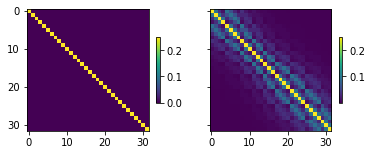

In [63]:
# make a list of parameter names
parnames = par.loc[par['pargp']=='hk', 'parnme'].tolist()

# get a submatrix from cov_pb; both row and column names must be the same if we want to retain a square matrix (which we do...)
subcov = parcov.get(row_names=parnames, col_names=parnames, drop=False)


# plot  both matrices side by side
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# plot submatrix of diagonal matrix
c = ax1.imshow(subcov.as_2d)
plt.colorbar(c, ax=ax1, shrink=0.3)
# plot cov matrix of correlated parameters
c = ax2.imshow(0.25 * cov.as_2d) #scaled to parameter unc
plt.colorbar(c, ax=ax2, shrink=0.3)

The singular values are the diagonal entries of the matrix, arranged in descending order. These can be accessed with the `.s` attribute. This still returns a `Matrix` object (technically a vector). Values in the matrix can be accessed in the same fashion as described above.

In [64]:
# get the singular values vector
cov_singular_values = cov.s

# access the entries in the vector
cov_singular_values.x

array([[3.84246373],
       [3.11801744],
       [2.21074436],
       [2.00413864],
       [1.72163322],
       [1.51391351],
       [1.3345163 ],
       [1.09049222],
       [1.04993872],
       [0.96437719],
       [0.88954002],
       [0.85212326],
       [0.83819113],
       [0.75506983],
       [0.71132262],
       [0.67704189],
       [0.6521505 ],
       [0.61622523],
       [0.60499669],
       [0.58513388],
       [0.57262865],
       [0.55759783],
       [0.5400864 ],
       [0.53382647],
       [0.51849182],
       [0.50579968],
       [0.48740815],
       [0.4747049 ],
       [0.46405699],
       [0.45251911],
       [0.43717383],
       [0.42367577]])

"Right singular vectors" are obtained with `.v` attribute:

In [65]:
cov.v

Matrices can be written to, and read from, external files. These can be ASCII or binary type files. As you saw above, we can access numpy arrays with the `.as_2d` attribute. They can also be converted to a Pandas Dataframe.

In [66]:
covdf = cov.to_dataframe()
covdf.head()

,pp_0000,pp_0001,pp_0002,pp_0003,pp_0004,pp_0005,pp_0006,pp_0007,pp_0008,pp_0009,...,pp_0022,pp_0023,pp_0024,pp_0025,pp_0026,pp_0027,pp_0028,pp_0029,pp_0030,pp_0031
pp_0000,1.000000,0.367879,0.135335,0.049787,0.367879,0.243117,0.106878,0.042329,0.135335,0.059106,...,0.002282,0.001792,0.001221,0.000912,0.000849,0.000689,0.000493,0.000315,0.000262,0.000195
pp_0001,0.367879,1.000000,0.367879,0.135335,0.243117,0.367879,0.243117,0.106878,0.106878,0.106878,...,0.002479,0.002282,0.001792,0.000849,0.000912,0.000849,0.000689,0.000335,0.000315,0.000262
pp_0002,0.135335,0.367879,1.000000,0.367879,0.106878,0.243117,0.367879,0.243117,0.059106,0.135335,...,0.002282,0.002479,0.002282,0.000689,0.000849,0.000912,0.000849,0.000315,0.000335,0.000315
pp_0003,0.049787,0.135335,0.367879,1.000000,0.042329,0.106878,0.243117,0.367879,0.027172,0.106878,...,0.001792,0.002282,0.002479,0.000493,0.000689,0.000849,0.000912,0.000262,0.000315,0.000335
pp_0004,0.367879,0.243117,0.106878,0.042329,1.000000,0.367879,0.135335,0.049787,0.367879,0.106878,...,0.006103,0.004584,0.002935,0.002479,0.002282,0.001792,0.001221,0.000849,0.000689,0.000493


In [67]:
# write to ascii; .to_binary() for binary format
cov.to_ascii(filename=os.path.join(f_d,'ppoint.cov'))

In [68]:
# read from ascii
cov = cov.from_ascii(filename=os.path.join(f_d,'ppoint.cov'))

In [69]:
# a PEST uncertainty file
cov.to_uncfile(os.path.join(f_d,'test.unc'))

Jacobian matrices, recorded by PEST(++) during parameter estimation, can be read and manipulated with the `Jco` class. This calss has the same functioanlity as the `Matrix` class.

In [70]:
jco = pyemu.Jco.from_binary(os.path.join(f_d,"freyberg_pp.jcb"))

jco.shape

(1435, 48)

### 7. Linear Analysis or FOSM

FOSM stands for "First Order, Second Moment". You may also see this referred to as "linear analysis" (e.g. in PEST documentation). We will delve into FOSM in more detail in another tutorial. Here we merely provide a brief introduction.

The ``pyemu.Schur`` object is one of the primary object for FOSM in `pyemu`. Instantiating a `Schur` object requires, at minimum, a Jacobian matrix and a PEST(++) control file.  From these, `pyemu` builds the prior parameter covariance matrix (from parameter bounds) and the observation noise covariance matrix (from observation weights). Alternatively, the parameter and observation covariance matrices can be provided explicitly.

Optionaly, observation names can be specified as forecasts. The `Schur` object extracts the corresponding rows from the Jacobian matrix to serve as forecast sensitivity vectors.

As we saw earlier, there is a Jacobian matrix in the tutorial folder, recorded in the file named `freyberg_pp.jcb`. 

In [71]:
sc = pyemu.Schur(os.path.join(f_d,'freyberg_pp.jcb'), verbose=False)

The prior parameter covariance matrix is stored in the `.parcov` attribute:

In [72]:
sc.parcov.to_dataframe().head()

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
hk00,0.25,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk01,0.00,0.25,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk02,0.00,0.00,0.25,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk03,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk04,0.00,0.00,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The same for the observation noise covariance matrix:

In [73]:
sc.obscov.to_dataframe().head()

,c001cr03c10_19700102,c001cr03c16_19700102,c001cr04c09_19700102,c001cr10c02_19700102,c001cr14c11_19700102,c001cr16c17_19700102,c001cr22c11_19700102,c001cr23c16_19700102,c001cr25c05_19700102,c001cr27c07_19700102,...,vol_storage_19800101,vol_stream__19700102,vol_stream__19791231,vol_stream__19800101,vol_total_19700102,vol_total_19791231,vol_total_19800101,vol_wells_19700102,vol_wells_19791231,vol_wells_19800101
c001cr03c10_19700102,0.04,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr03c16_19700102,0.00,0.04,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr04c09_19700102,0.00,0.00,0.04,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr10c02_19700102,0.00,0.00,0.00,0.04,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c001cr14c11_19700102,0.00,0.00,0.00,0.00,0.04,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The **posterior** parameter covariance matrix is calculated and stored in the `.posterior_parameter` attribute:

In [74]:
sc.posterior_parameter.to_dataframe().head()

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
hk00,0.244830,-0.008895,0.007299,0.002543,-0.017660,-0.015716,0.005581,0.001553,-0.007468,0.000299,...,1.072802e-52,4.651382e-53,3.983267e-53,4.501561e-53,3.255734e-55,1.572642e-55,3.965351e-56,1.380231e-56,1.345158e-56,-2.440006e-55
hk01,-0.008895,0.206416,0.009244,0.036372,-0.026315,-0.040258,-0.019464,0.004447,-0.012274,-0.008885,...,-2.849370e-52,1.774938e-53,2.074674e-53,-1.602939e-52,-5.513671e-55,-2.928261e-55,-5.005879e-55,-1.632710e-55,-1.644243e-55,-5.936551e-55
hk02,0.007299,0.009244,0.175363,-0.063715,0.019540,-0.007084,-0.065003,-0.048744,0.005867,-0.028997,...,-1.505624e-51,-4.791185e-52,-4.094703e-52,-9.587598e-52,-1.616659e-54,-8.162026e-55,-9.029515e-55,-2.927028e-55,-2.931907e-55,1.202457e-54
hk03,0.002543,0.036372,-0.063715,0.144853,0.001094,0.005050,-0.018862,-0.055774,0.000824,-0.015184,...,-1.755048e-51,-2.653509e-52,-2.037283e-52,-6.910555e-52,-5.010778e-54,-2.508259e-54,-2.062730e-54,-6.824379e-55,-6.826708e-55,1.371760e-55
hk04,-0.017660,-0.026315,0.019540,0.001094,0.186267,-0.062307,0.014820,0.006380,-0.028052,-0.001403,...,8.766563e-52,2.036783e-52,1.653814e-52,3.207171e-52,2.682204e-54,1.328847e-54,8.331458e-55,2.757943e-55,2.745622e-55,-7.101447e-55


Let's record the prior and posterior coavariance matrix to external files (we will use these later):

In [75]:
prior_cov = sc.parcov
prior_cov.to_ascii(os.path.join(f_d, 'freyberg_pp.prior.cov'))

post_cov = sc.posterior_parameter
post_cov.to_ascii(os.path.join(f_d, 'freyberg_pp.post.cov'))

The ``Schur`` object found the "++forecasts()" optional pestpp argument in the control, found the associated rows in the Jacobian matrix file and extracted those rows to serve as forecast sensitivity vectors. lterantively, we can also pass a list of observation names to use as forecasts when instantiating the `Schur` object. (e.g.`pyemu.Schur("jacobian.jcb", forecasts=[obsname1, obsname2, etc...])`.)

In [76]:
sc.forecast_names

['travel_time',
 'fa_headwaters_0001',
 'c001fr16c17_19791231',
 'c001fr05c04_19791231']

In [77]:
# forecast sensitivity vectors stores as `Matrix` objects:
sc.forecasts.to_dataframe().head()

,travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231
hk00,356.367939,-7.405048,0.000463,-0.292268
hk01,597.032671,-28.231777,0.002083,-1.266727
hk02,812.241332,-37.950877,-0.000926,-1.252610
hk03,738.191231,-27.537541,-0.006248,-0.964508
hk04,719.677223,-32.628453,0.000926,-0.301987


In [78]:
# summary of forecast prior and posterior uncertainty
sc.get_forecast_summary()

,prior_var,post_var,percent_reduction
travel_time,6.851805e+08,4.490640e+08,34.460481
fa_headwaters_0001,8.430109e+05,6.322101e+05,25.005708
c001fr16c17_19791231,1.889666e-01,8.349993e-02,55.812338
c001fr05c04_19791231,6.836951e+00,1.270466e+00,81.417657


`pyemu` makes FOSM easy to undertake. It has lot's of usefull functionality. We will not go into further detail here. See the "intro to fosm" tutorial for a deeper dive.

### 8. Ensembles

The `pyemu.ParameterEnsemble` and `pyemu.ObservationEnsemble` ensemble classes store parameter or observation ensembles, respectively. These classes are `DataFrames` under the hood, allowing us to use all the baked in Pandas conveniences.

We will focus on the `pyemu.ParameterEnsemble` class. Similar concepts apply to `pyemu.ObservationEnsemble`.

Ensembles can be read from (and written to) external files, or generated by `pyemu` using one of several methods. These methods `draw` stochastic values from (multivariate) (log) gaussian, uniform and triangular distributions for parameters in a `Pst` control file.  Much of what we do is predicated on the gaussian distribution, so let's use that here by generating an ensemble with the `.from_gaussian_draw()` method. 

Note that these `draw` methods use initial parameter values in the control file (the `Pst.parameter_data.parval1` attribute) the $\boldsymbol{\mu}$  (mean) prior parameter vector.  Unless otherwise specified, the parameter bounds are assumed to represent six standard deviations of the parameter probability distribution (i.e. ~99% of parameter values lie within the lower and upper bounds). 

In [79]:
# before continuing, we are going to re-load the pest control file to get rid of any changes we introduced
pst = pyemu.Pst(os.path.join(f_d,"freyberg_pp.pst"))

In [80]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst, # the Pst control file object, parameter data here will be used to characterize the ensembles' parameter statisctical distribution
                                                num_reals=200) # the number of realisations to generate
                                                

We can express parameter correlation by passing a covariance matrix to the `cov` argument. In doing so, the covariance matrix describes the second moement (the standard deviation) of the gaussian distribution. This allows us to draw parameter ensembles respecting parameter covariance. 

In [81]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst,           # the Pst control file object, parameter data here will be used to characterize the ensembles' parameter statisctical distribution
                                                num_reals=200, # the number of realisations to generate
                                                cov=prior_cov)    # specify parameter covariance; in this case, `parcov` doesn't actualy specify any covariance, but you get the idea...

Because the Ensemble is stored as a DataFrame, we can easily access it. Each row is an individual realisation. Each column is a parameter.

In [82]:
pe.head()

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
0,4.282251,0.515513,7.223507,6.598328,3.976811,13.535871,0.270134,7.083131,2.048404,3.683788,...,0.903788,1.025566,1.312461,0.872655,0.811879,0.436411,2.242973,0.355375,0.966883,2.134213
1,2.976066,1.180545,3.497429,45.684562,1.567815,6.020359,14.559707,2.636632,3.726345,38.282455,...,0.685774,1.883592,1.395199,1.267102,1.833112,1.181557,6.275507,0.620140,1.077183,0.150306
2,29.317058,3.487239,8.351074,4.415397,3.004822,16.145483,5.971614,2.112364,2.379113,1.515109,...,1.791839,0.998246,0.967017,1.484172,0.654332,2.742581,3.145955,3.422599,1.326742,0.286130
3,1.709065,1.389110,3.479177,12.573553,10.966852,22.722124,5.297299,1.799255,31.481663,8.067702,...,0.832192,1.092288,1.183589,0.568519,0.420843,0.675903,3.503355,1.133376,4.211715,0.850177
4,9.302456,4.684586,41.817348,2.917515,6.320494,3.794088,3.437952,6.623821,2.016632,4.290341,...,1.186924,1.037061,0.960814,0.604084,0.187716,0.803481,0.965624,2.498882,0.637866,4.123936


Let's plot a histogram of values generated for one of the parameters:

Text(0, 0.5, 'number of realisations')

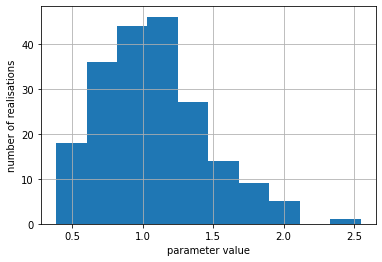

In [83]:
pe.loc[:, 'rch_0'].hist()
plt.xlabel('parameter value')
plt.ylabel('number of realisations')

In [84]:
# chekc the parmeter bounds; do any of the histogram bnis fall above/below the upper/lower bound value?
par.loc['rch_0', ['parlbnd','parubnd']]

parlbnd    0.5
parubnd    2.0
Name: rch_0, dtype: object

As you can see, parameter bounds may be violated when drawing the ensemble. The `.enforce()` method goes through it and makes sure that bounds are respected. It does this by assigning the bound value to any parameter values which exceed the bound.

As you can see in the subsequent plot, bounds are now respected:

Text(0, 0.5, 'number of realisations')

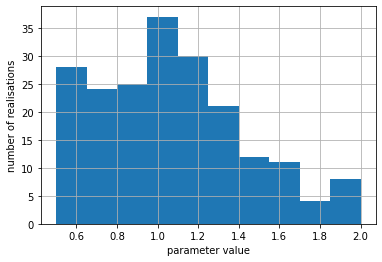

In [85]:
# enforce parmeter bounds
pe.enforce()

# plot again
pe.loc[:, 'rch_0'].hist()
plt.xlabel('parameter value')
plt.ylabel('number of realisations')

There are also built in functions to automate plotting:

<Figure size 576x756 with 0 Axes>

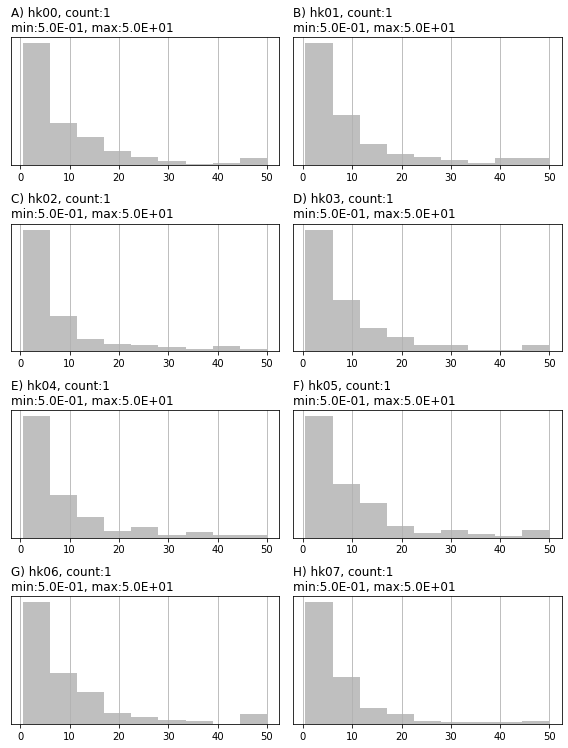

In [86]:
# generates a A4 page of histograms for specified columns (e.g. parameters)

# slect column (e.g. parameter) names
plot_cols = pe.columns[0:8].tolist() 

# plot histograms
pe.plot(bins=10, 
        plot_cols=plot_cols, # specifyes which columns to plot
        filename=None, )     # external filename to record plot

You can record an ensemble to external files (.csv of binary):

In [87]:
pe.to_csv(os.path.join(f_d, 'prior_pe.csv'))

And of course, read from external files (csv, binary) or even from pandas DataFrames:

In [88]:
pe = pyemu.ParameterEnsemble.from_csv(pst, filename=os.path.join(f_d, 'prior_pe.csv'))

We can even form an empirical covariance matrix from an ensemble!

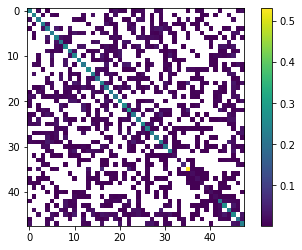

In [89]:
emp_cov = pe.covariance_matrix()

# display for fun
x = emp_cov.x.copy()
x[x<1.0e-3] = np.NaN
c = plt.imshow(x)
plt.colorbar(c)

#### 8.1 Bayes Linear Monte Carlo

We can use the bayes linear posterior parameter covariance matrix (aka Schur compliment) to "precondition" the realizations using linear algebra so that they hopefully yield a lower phi.  The trick is we just need to pass this
posterior covariance matrix to the draw method.  Note this covariance matrix is the second moment of the posterior (under the FOSM assumptions) and the final parameter values is the first moment.

In other GMDSI educational material, and in the PEST Roadmaps, this approach is sometimes referred to as "using the linearized posterior parameter distribution". 

Applying Bayes linear Monte Carlo requires that we have previously calibrated a model and calculated a post-calibration Jacobian matrix.  From the Jacobian, we can obtain the post-calibration parameter covariance. The "calibrated" parameter values represent the mean of the posterior parameter probability distribution. By centering the distribution on values that already provide a good fit with measurment data, we are increasing the likelihood that the realisatiosn that we draw will also fit measured data well. This can be usefull in reducing subsequent history-matching computation time.


In [90]:
pe_post = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,
                                                    cov=post_cov, 
                                                    num_reals=200)
pe_post.enforce()

drawing from group hk
drawing from group porosity
drawing from group rch
drawing from group sfr
drawing from group w0


drawing from group w1


<AxesSubplot:>

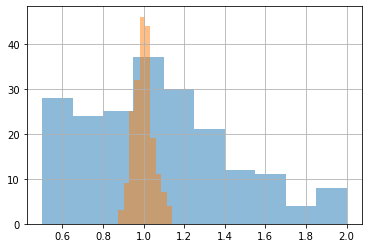

In [91]:
# comapre the prior and the posterior
pe.loc[:, 'rch_0'].hist(alpha=0.5)
pe_post.loc[:, 'rch_0'].hist(alpha=0.5)
#pe_post.loc[:, 'hk00'].plot(kind="hist",bins=20,ax=ax,alpha=0.5)

return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame


[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

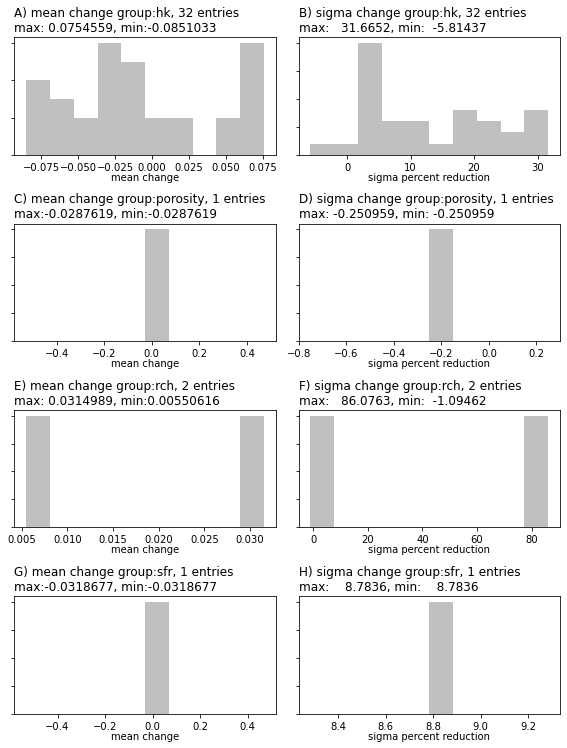

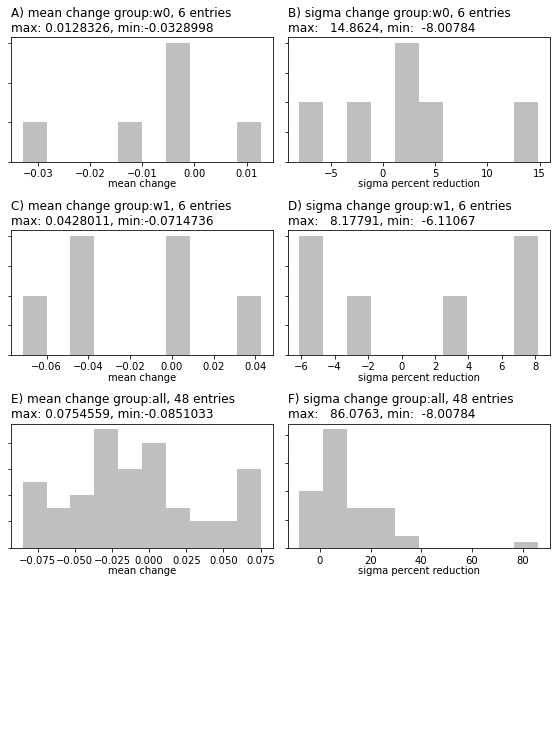

In [92]:
# plots the change between two ensembles
pyemu.plot_utils.ensemble_change_summary(pe, pe_post, pst)

Or for comparing histograms from several ensembles. (Can also be used for observation ensembles; see additional method arguments):

<Figure size 576x756 with 0 Axes>

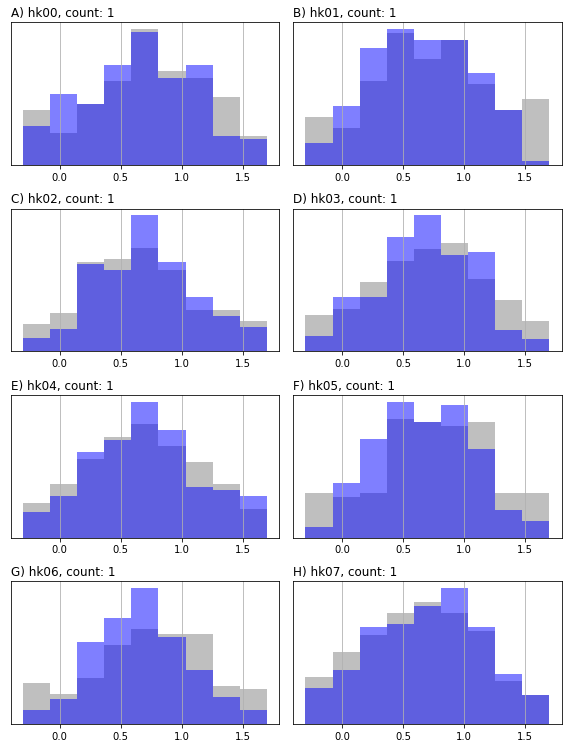

In [93]:
pyemu.plot_utils.ensemble_helper(ensemble={"0.5":pe, "b":pe_post,},
                                     filename=None,
                                     plot_cols=plot_cols,
                                     )